In [ ]:
from langchain_core.pydantic_v1 import BaseModel, Field
from langchain_groq import ChatGroq
from langchain_core.prompts import ChatPromptTemplate
from typing_extensions import TypedDict
from langgraph.graph import StateGraph, END

class AgentState(TypedDict):
    question: str
    transaction_category: str
    llm_output: str
    on_topic: bool

class GradeQuestion(BaseModel):
    """Boolean value to check whether a question is related to the crypto-related payment."""
    score: str = Field(description="Question is about crypto-related payment? If yes -> 'Yes' if not -> 'No'")

def question_classifier(state: AgentState):
    question = state["question"]

    system = """You are a grader assessing the relevance and completeness of user questions. \n
    Only answer "Yes" if the question is about one of the following AND includes all necessary details:
    1. Crypto to INR transaction.
    2. INR to Crypto transaction.
    3. Crypto to Crypto transaction.
    
    Necessary details include:
    - The amount (e.g., "3000 INR", "0.5 BTC").
    - The currency unit (e.g., "INR", "BTC", "ETH").
    - The receiver's name or wallet address (e.g., "to John", "to 0x437463846382293846").

    If the question IS about these topics AND includes all necessary details, respond with "Yes". Otherwise, respond with "No".

    Examples of relevant and complete questions:
    - "Send 3000 INR to John from my wallet." (Crypto to INR)
    - "Transfer 0.5 BTC to 0x437463846382293846." (Crypto to Crypto)
    - "Can I send 2000 rupees to the wallet address 0x123456789?" (INR to Crypto)
    - "I want to convert 1 ETH to INR and send it to Alice." (Crypto to INR)
    - "Send 5000 INR to my crypto wallet at 0x987654321." (INR to Crypto)
    -"Send 300 INR to wallet address 0x3800a81C0C5dafbF7a973e2894790fa607296020
    - "Convert 0.1 BTC to rupees and transfer it to Bob." (Crypto to INR)
    - "How can I send 300rs to the wallet address 0xabcdef123456?" (INR to Crypto)
    - "I need to transfer 0.3 ETH to another wallet at 0x654321fedcba." (Crypto to Crypto)
    - "What’s the process to send 10000 INR from my bank to the wallet address 0x123abc456def?" (INR to Crypto)
    - "Transfer 0.001 eth to UPI address or VPA." -> (Crypto to INR)
    -  "Transfer 0.001 eth to sarthak610@oksbi" -> (Crypto to INR)

    Examples of incomplete or irrelevant questions:
    - "Send 3000 INR." (Missing receiver details)
    - "How do I transfer BTC?" (Missing amount and receiver details)
    - "Can I send rupees to a crypto wallet?" (Missing amount and wallet address)
    - "I want to convert ETH to INR." (Missing receiver details)
    - "Transfer BTC to another wallet." (Missing amount and wallet address)
    - "What’s the weather today?" (Irrelevant)
    - "How do I cook pasta?" (Irrelevant)
    - "Tell me about the history of Bitcoin." (Irrelevant)
    - "What’s the price of gold?" (Irrelevant)

    Respond with "Yes" only if the question is about crypto-to-INR, INR-to-crypto, or crypto-to-crypto transactions AND includes all necessary details. Otherwise, respond with "No".
    """

    grade_prompt = ChatPromptTemplate.from_messages([
        ("system", system),
        ("human", "User question: {question}"),
    ])

    llm = ChatGroq(groq_api_key="", model_name="Gemma2-9b-It")
    structured_llm = llm.with_structured_output(GradeQuestion)
    grader_llm = grade_prompt | structured_llm
    result = grader_llm.invoke({"question": question})
    state["on_topic"] = result.score
    return state

class TransactionType(BaseModel):
    """Identifies the type of transaction based on user input."""
    category: str = Field(description="Transaction category: 'crypto_to_inr', 'inr_to_crypto', or 'crypto_to_crypto'")

def on_topic_router(state: AgentState):
    on_topic = state["on_topic"]
    if on_topic.lower() == "yes":
        return "on_topic"
    return "off_topic"

def off_topic_response(state: AgentState):
    state["llm_output"] = "I can't respond to that!"
    return state

def classify_transaction(state: AgentState):
    question = state["question"]

    system = """You are an AI agent responsible for classifying user transactions into three categories: 
    1. 'crypto_to_inr' - When the user requests to send INR (denoted as 'INR', 'Rs', or '₹') to a receiver from their crypto wallet.
    2. 'inr_to_crypto' - When the user requests to send INR (denoted as 'INR', 'Rs', or '₹') to a cryptocurrency wallet (e.g., an address starting with '0x' or other crypto address formats).
    3. 'crypto_to_crypto' - When the user requests to send cryptocurrency to a receiver from their crypto wallet.

    Examples of relevant and complete questions:
    - "Send 0.3 BTC to receiver from my wallet." -> 'crypto_to_crypto'
    - "Transfer 300rs to the wallet address 0x437463846382293846." -> 'inr_to_crypto'
    - "Convert 0.5 BTC to INR and transfer it to Alice." -> 'crypto_to_inr'
    - "I want to send 5000 INR to my Bitcoin wallet." -> 'inr_to_crypto'
    - "Send 0.3 ETH to receiver from my bank account." -> 'inr_to_crypto'
    - "Transfer 0.1 ETH to the wallet address 0x654321fedcba." -> 'crypto_to_crypto'
    - "I want to send 2000 rupees from my crypto wallet to my bank account." -> 'crypto_to_inr'
    - "Can I transfer 10000 rupees to the Ethereum address 0x123456789?" -> 'inr_to_crypto'
    - "How do I send 2000 INR to a crypto wallet?" -> 'inr_to_crypto'
    - "Transfer 1 ETH to INR and send it to Bob." -> 'crypto_to_inr'
    - "I want to send 0.5 BTC to another wallet." -> 'crypto_to_crypto'
    - "Can I transfer 0.2 ETH to the address 0xabcdef123456?" -> 'crypto_to_crypto'
    - "How do I convert 0.2 BTC to rupees and send it to my friend?" -> 'crypto_to_inr'
    - "How do I send 0.4 BTC to my friend’s wallet?" -> 'crypto_to_crypto'
    - "Transfer 0.001 eth to UPI address or VPA." -> 'crypto_to_inr'
    -  "Transfer 0.001 eth to sarthak610@oksbi" -> 'crypto_to_inr'

    Examples of incomplete or irrelevant questions:
    - "Send 3000 INR." (Missing receiver details)
    - "How do I transfer BTC?" (Missing amount and receiver details)
    - "Can I send rupees to a crypto wallet?" (Missing amount and wallet address)
    - "I want to convert ETH to INR." (Missing receiver details)
    - "Transfer BTC to another wallet." (Missing amount and wallet address)
    - "What’s the weather today?" (Irrelevant)
    - "How do I cook pasta?" (Irrelevant)
    - "Tell me about the history of Bitcoin." (Irrelevant)
    - "What’s the price of gold?" (Irrelevant)
    Classify the user's input strictly into one of these categories.
    """

    classify_prompt = ChatPromptTemplate.from_messages([
        ("system", system),
        ("human", "User transaction request: {question}"),
    ])

    llm = ChatGroq(groq_api_key="", model_name="Gemma2-9b-It")
    structured_llm = llm.with_structured_output(TransactionType)
    classifier = classify_prompt | structured_llm

    result = classifier.invoke({"question": question})
    state["transaction_category"] = result.category
    return state

def router(state: AgentState):
    transaction_type = state["transaction_category"].lower()
    if transaction_type == "crypto_to_inr":
        return "crypto_to_inr"
    elif transaction_type == "inr_to_crypto":
        return "inr_to_crypto"
    else:
        return "crypto_to_crypto"

def crypto_to_inr(state: AgentState):
    state["llm_output"] = "Converting crypto to INR"
    return state

def inr_to_crypto(state: AgentState):
    state["llm_output"] = "Converting INR to crypto"
    return state

def crypto_to_crypto(state: AgentState):
    state["llm_output"] = "Starting crypto transaction"
    return state

workflow = StateGraph(AgentState)

workflow.add_node("request_classifier", question_classifier)
workflow.add_node("off_topic_response", off_topic_response)
workflow.add_node("classify_transaction", classify_transaction)
workflow.add_node("crypto_to_inr", crypto_to_inr)
workflow.add_node("inr_to_crypto", inr_to_crypto)
workflow.add_node("crypto_to_crypto", crypto_to_crypto)

workflow.add_conditional_edges(
    "request_classifier",
    on_topic_router,
    {
        "on_topic": "classify_transaction",
        "off_topic": "off_topic_response",
    },
)

workflow.add_edge("off_topic_response", END)

workflow.add_conditional_edges(
    "classify_transaction",
    router,
    {
        "crypto_to_inr": "crypto_to_inr",
        "inr_to_crypto": "inr_to_crypto",
        "crypto_to_crypto": "crypto_to_crypto"
    },
)

workflow.add_edge("crypto_to_inr", END)
workflow.add_edge("inr_to_crypto", END)
workflow.add_edge("crypto_to_crypto", END)

workflow.set_entry_point("request_classifier")

app = workflow.compile()

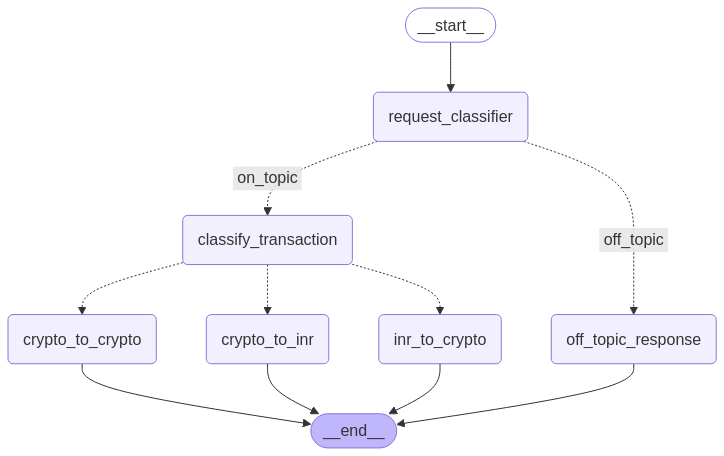

In [43]:
from IPython.display import Image, display

try:
    display(Image(app.get_graph(xray=True).draw_mermaid_png()))
except:
    pass

In [44]:
result = app.invoke({"question": "Send 3000 INR to amit from my wallet."})
print(result["llm_output"])


Converting INR to crypto
